## Initialize Dependencies

In [1]:
import os
from utilities import init_db_handle
from couchbase.n1ql import N1QLQuery
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
import folium
from folium import plugins
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Initialize Database Handle

In [2]:
data_folder = './Data'
cb = init_db_handle(data_folder)

-[Return list of document identifier](https://forums.couchbase.com/t/how-n1ql-get-doc-id/4161/2)  
-[Import N1QL query speed](https://dzone.com/articles/count-amp-group-faster-using-n1ql)  
-[Fill a list from a generator](https://stackoverflow.com/questions/9811222/fill-a-list-from-a-generator)

## Query a database record

In [3]:
row_iter = cb.n1ql_query(N1QLQuery('SELECT meta(AustinTx311Data).id FROM AustinTx311Data LIMIT 1'))
recordid = [elem['id'] for elem in itertools.islice(row_iter,None)]
rec = cb.get(recordid[0])
rec.value

{'city': 'AUSTIN',
 'closeday': 4,
 'closehour': 12,
 'closemonth': 1,
 'closeyear': 2014,
 'councildistrict': 10,
 'county': 'TRAVIS',
 'createdday': 1,
 'createdhour': 1,
 'createdmonth': 1,
 'createdyear': 2014,
 'lastupdateday': 4,
 'lastupdatehour': 11,
 'lastupdatemonth': 1,
 'lastupdateyear': 2014,
 'latitudecoordinate': 30.3484472,
 'latitudelongitude': {'loc': [30.3484472, -97.77776831],
  'title': '14-00000197'},
 'longitudecoordinate': -97.77776831,
 'mappage': '524P',
 'maptile': 'MG29',
 'methodreceived': 'Phone',
 'owningdepartment': 'Animal Services Office',
 'srdescription': 'Dangerous/Vicious Dog Investigation',
 'srlocation': '4507 KNAP HOLW, AUSTIN, TX',
 'srstatus': 'Closed',
 'srtypecode': 'COAACDD',
 'stateplanexcoordinate': 3102607.36012251,
 'stateplaneycoordinate': 10099724.3223682,
 'statuschangeday': 4,
 'statuschangehour': 12,
 'statuschangemonth': 1,
 'statuschangeyear': 2014,
 'streetname': 'KNAP',
 'streetnumber': 4507,
 'zipcode': 78731}

## Initialize a Secondary Index

In [4]:
cb.n1ql_query(N1QLQuery('CREATE INDEX idxsrtypecode ON `AustinTx311Data` (srtypecode)'))
cb.n1ql_query(N1QLQuery('CREATE INDEX idxcreatedyear ON `AustinTx311Data` (createdyear)'))
cb.n1ql_query(N1QLQuery('CREATE INDEX idxcreatedmonth ON `AustinTx311Data` (createdmonth)'))

## Compute a histogram of 311 calls / year
-[Sort DataFrame month colunn](https://stackoverflow.com/questions/46755841/pandas-dataframe-month-int-to-month-name-in-order)  
-[Print *.png wihtout cropping](https://stackoverflow.com/questions/37427362/plt-show-shows-full-graph-but-savefig-is-cropping-the-image)

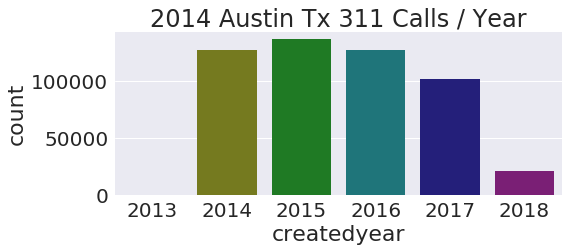

In [19]:
request = cb.n1ql_query(N1QLQuery('SELECT createdyear, count(*) from `AustinTx311Data` GROUP BY createdyear;'))

histogram = [{'createdyear': elem['createdyear'], 'count': elem['$1']}
             for elem in itertools.islice(request, None) if elem['createdyear'] is not None]

histogram = np.array(histogram)
createdyear = np.array([elem['createdyear'] for elem in histogram])
histogram = histogram[np.argsort(createdyear)]
df = pd.DataFrame(list(histogram))

plt.figure(figsize=(8,3))
sns.set(font_scale=2)
sns.set_palette(sns.hls_palette(df.shape[0], l=.3, s=.8))
sns.barplot(x='createdyear', y='count', data=df)
plt.title('2014 Austin Tx 311 Calls / Year')
plt.savefig('countsPerYear.png')

## Compute a histogram of 311 calls for 2014

In [7]:
year = 2014

request = cb.n1ql_query(N1QLQuery('SELECT createdmonth, count(*) from `AustinTx311Data`' +\
                                  'WHERE createdyear=' + str(year) + ' GROUP BY createdmonth'));

histogram = [{'createdmonth': elem['createdmonth'], 'count': elem['$1']}
             for elem in itertools.islice(request, None)]

createdmonth = [elem['createdmonth'] for elem in histogram]

histogram = np.array(histogram)
histogram = histogram[np.argsort(createdmonth)]

for idx in range(0, len(histogram)):
    datetimeobj = datetime(year, histogram[idx]['createdmonth'], 1)
    histogram[idx]['createdmonth'] = datetimeobj.strftime('%b')

df = pd.DataFrame.from_dict(list(histogram))

### Plot 2014 311 calls / month histogram
-[Pandas Dataframe barplot](https://stackoverflow.com/questions/35168016/unable-to-plot-dataframe-using-seaborn-barplot)  
-[Style Seaborn plot](https://seaborn.pydata.org/tutorial/aesthetics.html)  
-[Set Seaborn font size](https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid)  

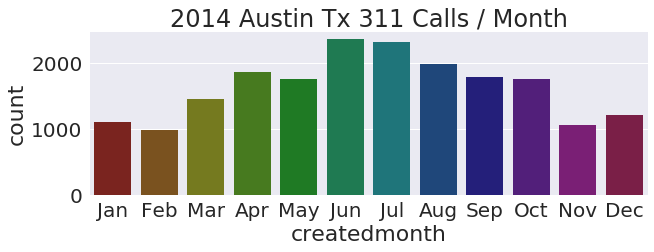

In [16]:
plt.figure(figsize=(10,3))
sns.set(font_scale=2)
sns.set_palette(sns.hls_palette(df.shape[0], l=.3, s=.8))
sns.barplot(x='createdmonth', y='count', data=df)
plt.title('2014 Austin Tx 311 Calls / Month')
plt.savefig('countsPerMonth2014.png', bbox_inches = 'tight')

## Compute service type histogram for 2014
-[Normalize Pandas DataFrame column](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame)

In [9]:
request = cb.n1ql_query(N1QLQuery('SELECT srtypecode, count(*) FROM `AustinTx311Data` ' +\
                                  'WHERE createdyear=2014 GROUP BY srtypecode;'))

srtypecode_histogram = [{'srtypecode': elem['srtypecode'], 'count': elem['$1'], 'srdescription':None}
                        for elem in itertools.islice(request, None)]

for row in range(0, len(srtypecode_histogram)):
    query_string = "SELECT srdescription from `AustinTx311Data` " +\
                   "WHERE srtypecode='" + srtypecode_histogram[row]['srtypecode'] +\
                   "' LIMIT 1;"

    request = cb.n1ql_query(N1QLQuery(query_string))
    srtypecode_histogram[row]['srdescription'] = request.get_single_result()['srdescription']
    
df = pd.DataFrame.from_dict(srtypecode_histogram)
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index(drop=True)

df['percentage'] = 100*df['count'].values.astype('float')/np.sum(df['count'])
df['cumulativepercentage'] = np.cumsum(df['percentage'].values)

In [10]:
idx = np.argmin(np.abs(df['cumulativepercentage'].values - 70))
segmented_df = df.head(idx + 1)
segmented_df

,count,srdescription,srtypecode,percentage,cumulativepercentage
0,19646,Austin Code - Request Code Officer,CODECOMP,15.426534,15.426534
1,9740,Loose Dog,ACLONAG,7.648093,23.074628
2,8996,Traffic Signal - Maintenance,TRASIGMA,7.063886,30.138514
3,6677,Loud Music,LOUDMUS1,5.242949,35.381462
4,6308,Animal Control - Assistance Request,ACINFORM,4.953201,40.334663
5,5684,Graffiti Abatement,HHSGRAFF,4.463220,44.797883
6,5476,ARR Missed Recycling,SWSRECYC,4.299893,49.097776
7,5431,ARR Dead Animal Collection,SWSDEADA,4.264558,53.362334
8,4781,Water Waste Report,WWREPORT,3.754162,57.116496
9,4555,Street Light Issue- Address,STREETL2,3.576701,60.693197


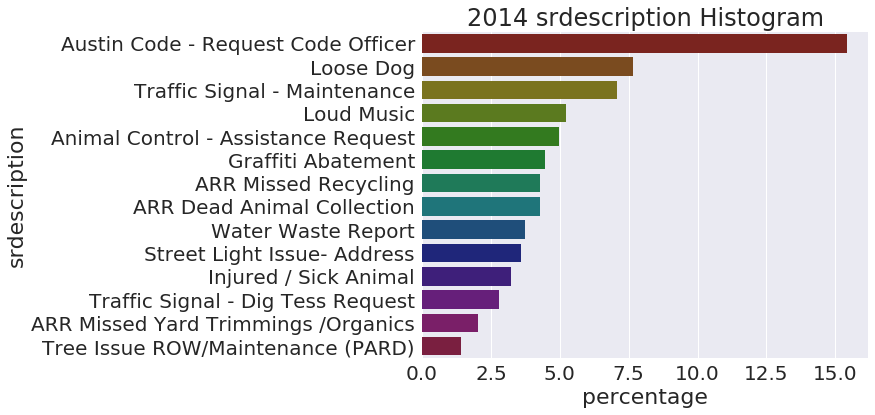

In [17]:
sns.set(font_scale=2)
plt.figure(figsize=(8,6))
sns.set_palette(sns.hls_palette(segmented_df.shape[0], l=.3, s=.8))
h_barplot = sns.barplot(x="percentage", y="srdescription", data=segmented_df, label="percentage")
plt.title('2014 srdescription Histogram')
plt.savefig('2014_srdescription_hist.png', bbox_inches = 'tight')

## Compute Code Compliance Music 2014 histogram

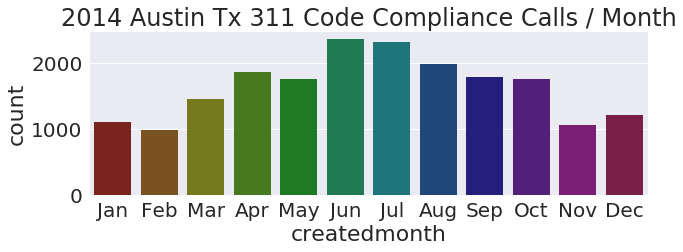

In [18]:
request = cb.n1ql_query(N1QLQuery("SELECT createdmonth, count(*) from `AustinTx311Data` " +
                                  "WHERE srtypecode='CODECOMP' AND createdyear=2014 GROUP BY createdmonth;"))

histogram = [{'createdmonth': elem['createdmonth'], 'count': elem['$1']}
             for elem in itertools.islice(request, None)]

createdmonth = [elem['createdmonth'] for elem in histogram]

histogram = np.array(histogram)
histogram = histogram[np.argsort(createdmonth)]

for idx in range(0, len(histogram)):
    datetimeobj = datetime(year, histogram[idx]['createdmonth'], 1)
    histogram[idx]['createdmonth'] = datetimeobj.strftime('%b')

df = pd.DataFrame.from_dict(list(histogram))

plt.figure(figsize=(10,3))
sns.set(font_scale=2)
sns.set_palette(sns.hls_palette(df.shape[0], l=.3, s=.8))
sns.barplot(x='createdmonth', y='count', data=df)
plt.title('2014 Austin Tx 311 Code Compliance Calls / Month')
plt.savefig('countsPerMonth2014.png', bbox_inches = 'tight')

In [14]:
request = cb.n1ql_query(N1QLQuery("SELECT latitudecoordinate, longitudecoordinate from `AustinTx311Data` " +
                                  "WHERE srtypecode='CODECOMP' AND createdyear=2014 and createdmonth=6"));

coordinates = [(elem['latitudecoordinate'],
                elem['longitudecoordinate']) for elem in itertools.islice(request, None)]

center_latitude = np.mean([elem[0] for elem in coordinates])
center_longitude = np.mean([elem[1] for elem in coordinates])

map_osm = folium.Map(location=[center_latitude, center_longitude], zoom_start=10)
map_osm.add_child(plugins.HeatMap(coordinates, min_opacity=0.05))
display(map_osm)

In [15]:
request = cb.n1ql_query(N1QLQuery("SELECT latitudecoordinate, longitudecoordinate from `AustinTx311Data` " +
                                  "WHERE srtypecode='CODECOMP' AND createdyear=2014 and createdmonth=6"));

coordinates = [(elem['latitudecoordinate'],
                elem['longitudecoordinate']) for elem in itertools.islice(request, None)]

center_latitude = np.mean([elem[0] for elem in coordinates])
center_longitude = np.mean([elem[1] for elem in coordinates])

map_osm = folium.Map(location=[center_latitude, center_longitude], zoom_start=12)
map_osm.add_child(plugins.HeatMap(coordinates, min_opacity=0.05))
display(map_osm)